In [1]:
# Standard library imports
import os

# Contributed library imports
import geopandas as gpd
import numpy as np
from pathlib import Path

# Our imports
from multiview_mapping_toolkit.meshes import TexturedPhotogrammetryMesh
from multiview_mapping_toolkit.utils.prediction_metrics import compute_and_show_cf
from multiview_mapping_toolkit.utils.geospatial import get_overlap_vector


/ofo-share/repos-david/conda/envs/MVMT-dev/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Set constants
You should be able to define most of the behavior from these constants

In [2]:
training_sites = ["chips", "delta"]
prediction_site_name = "valley"

In [3]:
## Parameters to control the outputs
# Repeat the labeling process
RETEXTURE = False
# Points less than this height (meters) above the DTM are considered ground
HEIGHT_ABOVE_GROUND_THRESH = 2
# The image is downsampled to this fraction for accelerated rendering
RENDER_IMAGE_SCALE = 0.25
# Cameras within this distance of the traing data are used in the rendering process
BUFFER_RADIUS_METERS = 50
# Downsample target
DOWNSAMPLE_TARGET = 1
# Image downsample factor for aggregation
AGGREGATE_IMAGE_SCALE = 0.25

## Python interpreter and script locations
MMSEG_UTILS_PYTHON = "/ofo-share/repos-david/conda/envs/mmseg-utils/bin/python"
MMSEG_PYTHON = "/ofo-share/repos-david/conda/envs/openmmlab/bin/python"

FOLDER_TO_CITYSCAPES_SCRIPT = "/ofo-share/repos-david/mmsegmentation_utils/dev/dataset_creation/folder_to_cityscapes.py"
VIS_PREDS_SCRIPT = "/ofo-share/repos-david/mmsegmentation_utils/dev/visualization/visualize_semantic_labels.py"
TRAIN_SCRIPT = "/ofo-share/repos-david/mmsegmentation/tools/train.py"
INFERENCE_SCRIPT = "/ofo-share/repos-david/mmsegmentation/tools/inference.py"

# One folder up from scripts
PROJECT_ROOT = Path(os.path.abspath(""), "..", "..", "..").resolve()
SCRATCH_ROOT = Path(Path.home(), "scratch", "organized_str_disp_MVMT_experiments")

IDs_TO_LABELS = {
    0: "ABCO",
    1: "CADE",
    2: "PILA",
    3: "PIPO",
    4: "PSME",
    5: "QUEV",
    6: "SNAG",
    7: "ground",
}

TRAINING_SITES_STR = "_".join(training_sites)

## Define the inputs
# The input labels
LABELS_FILENAME = Path(PROJECT_ROOT, "field_ref", "crowns_drone_w_field_data.geojson")
LABELS_COLUMN = "species_observed"

# The digital elevation map exported by Metashape
DTM_FILE = Path(
    PROJECT_ROOT,
    "per_site_processing",
    prediction_site_name,
    "02_photogrammetry",
    "exports",
    "dtms",
    f"{prediction_site_name}.tif",
)
IMAGES_NEAR_LABELS_FOLDER = Path(
    PROJECT_ROOT,
    "per_site_processing",
    prediction_site_name,
    "03_training_data",
    "images_near_labels",
)
prediction_site_long_name = {"valley": "ValleyA", "chips": "ChipsB", "delta": "DeltaB"}[
    prediction_site_name
]
IMAGE_FOLDER = f"/ofo-share/str-disp_drone-data-partial/str-disp_drone-data_imagery-missions/{prediction_site_long_name}"
PREDICTIONS_FOLDER = Path(
    PROJECT_ROOT,
    "per_site_processing",
    prediction_site_name,
    "04_model_preds",
    f"{TRAINING_SITES_STR}_MVMT_model",
)
PREDICTED_VECTOR_LABELS_FILE = Path(
    PROJECT_ROOT,
    "per_site_processing",
    prediction_site_name,
    "05_processed_predictions",
    f"{prediction_site_name}_80m_chips_model.geojson",
)
NUMPY_EXPORT_FACES_TEXTURE_FILE = Path(
    PROJECT_ROOT,
    "per_site_processing",
    prediction_site_name,
    "05_processed_predictions",
    f"{prediction_site_name}_80m_chips_model.npy",
)

In [4]:
MESH_FILENAME_BASE = Path(
    PROJECT_ROOT,
    "per_site_processing",
    prediction_site_name,
    "02_photogrammetry",
    "exports",
    "meshes",
)

CHIPS_MESH_FILENAME = Path(
    MESH_FILENAME_BASE,
    "ChipsB-120m_20230309T0502_w-mesh_w-80m_20231114T2219.ply",
)
# The mesh exported from Metashape
DELTA_MESH_FILENAME = Path(
    MESH_FILENAME_BASE,
    "DeltaB-120m_20230310T1701_w-mesh_w-80m_20231117T1746.ply",
)
# The mesh exported from Metashape
VALLEY_MESH_FILENAME = Path(
    MESH_FILENAME_BASE,
    "ValleyA-120m_20230323T0515_w-mesh.ply",
)
# The camera file exported from Metashape
CAMERAS_FILENAME_BASE = Path(
    PROJECT_ROOT,
    "per_site_processing",
    prediction_site_name,
    "02_photogrammetry",
    "exports",
    "cameras",
)
CHIPS_CAMERAS_FILENAME = Path(
    CAMERAS_FILENAME_BASE,
    "ChipsB-120m_20230309T0502_w-mesh_w-80m_20231114T2219_abs_paths.xml",
)
# The camera file exported from Metashape
DELTA_CAMERAS_FILENAME = Path(
    CAMERAS_FILENAME_BASE,
    "DeltaB-120m_20230310T1701_w-mesh_w-80m_20231117T1746_abs_paths.xml",
)
# The camera file exported from Metashape
VALLEY_CAMERAS_FILENAME = Path(
    CAMERAS_FILENAME_BASE,
    "ValleyA-120m_20230323T0515_w-mesh.xml",
)

MESH_FILENAME_DICT = {
    "chips": CHIPS_MESH_FILENAME,
    "delta": DELTA_MESH_FILENAME,
    "valley": VALLEY_MESH_FILENAME,
}
CAMERAS_FILENAME_DICT = {
    "chips": CHIPS_CAMERAS_FILENAME,
    "delta": DELTA_CAMERAS_FILENAME,
    "valley": VALLEY_CAMERAS_FILENAME,
}

MESH_FILENAME = MESH_FILENAME_DICT[prediction_site_name]
CAMERAS_FILENAME = CAMERAS_FILENAME_DICT[prediction_site_name]

# Ground truth classes

Loading transform to EPSG:4326
Loading mesh
Reading the mesh


Selecting an ROI from mesh
Standardizing ROI
Dissolving ROI
Setting CRS and buffering ROI
Dissolving buffered ROI
Extracting verts for dataframe
Checking intersection of verts with ROI
Extracting points from pyvista mesh
Extraction surface from subset mesh
Extracting faces from mesh
Loading texture
Could not read texture as a scalar from the pyvista mesh
Could not read texture as a numpy file


Sampling values from raster /ofo-share/scratch-david/organized-str-disp-MVMT-experiments/per_site_processing/valley/02_photogrammetry/exports/dtms/valley.tif: 100%|██████████| 134102/134102 [00:05<00:00, 23481.72it/s]


This method will be deprecated in favor of get_IDs_to_labels since it doesn't handle non-sequential indices


/ofo-share/repos-david/conda/envs/MVMT-dev/lib/python3.9/site-packages/pyvista/jupyter/notebook.py:33: UserWarning: Failed to use notebook backend: 

No module named 'trame.ui.vuetify'

Falling back to a static output.
  warnings.warn(


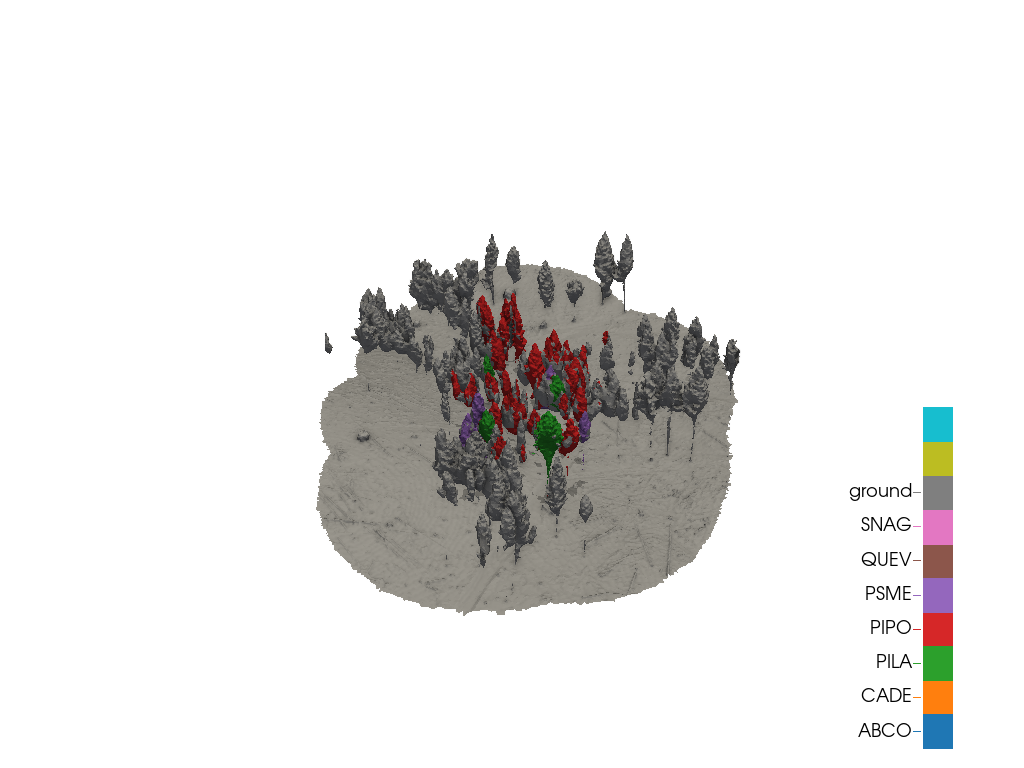

In [5]:
mesh = TexturedPhotogrammetryMesh(
    MESH_FILENAME,
    transform_filename=CAMERAS_FILENAME,
    texture=LABELS_FILENAME,
    texture_column_name=LABELS_COLUMN,
    ROI=LABELS_FILENAME,
    ROI_buffer_meters=BUFFER_RADIUS_METERS,
)
mesh.label_ground_class(
    height_above_ground_threshold=HEIGHT_ABOVE_GROUND_THRESH,
    DTM_file=DTM_FILE,
    set_mesh_texture=True,
)
mesh.vis(force_xvfb=True)

# Predicted classes

Loading transform to EPSG:4326
Loading mesh
Reading the mesh
Selecting an ROI from mesh
Standardizing ROI
Dissolving ROI
Setting CRS and buffering ROI
Dissolving buffered ROI
Extracting verts for dataframe
Checking intersection of verts with ROI
Extracting points from pyvista mesh
Extraction surface from subset mesh
Extracting faces from mesh
Loading texture
Could not read texture as a scalar from the pyvista mesh
This method will be deprecated in favor of get_IDs_to_labels since it doesn't handle non-sequential indices


/ofo-share/repos-david/conda/envs/MVMT-dev/lib/python3.9/site-packages/pyvista/jupyter/notebook.py:33: UserWarning: Failed to use notebook backend: 

No module named 'trame.ui.vuetify'

Falling back to a static output.
  warnings.warn(


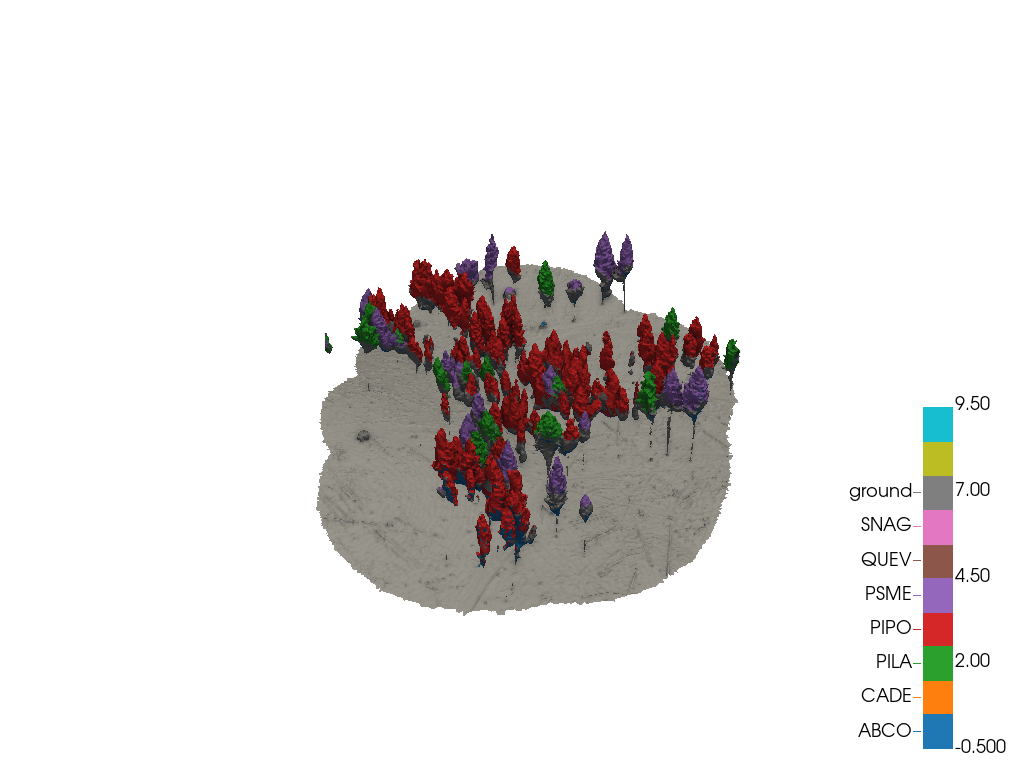

In [6]:
mesh = TexturedPhotogrammetryMesh(
    MESH_FILENAME,
    transform_filename=CAMERAS_FILENAME,
    texture=NUMPY_EXPORT_FACES_TEXTURE_FILE,
    IDs_to_labels=IDs_TO_LABELS,
    ROI=LABELS_FILENAME,
    ROI_buffer_meters=BUFFER_RADIUS_METERS,
)
mesh.vis(force_xvfb=True)

# Colored mesh

Loading transform to EPSG:4326
Loading mesh
Reading the mesh
Selecting an ROI from mesh
Standardizing ROI
Dissolving ROI
Setting CRS and buffering ROI
Dissolving buffered ROI
Extracting verts for dataframe
Checking intersection of verts with ROI
Extracting points from pyvista mesh
Extraction surface from subset mesh
Extracting faces from mesh
Loading texture


/ofo-share/repos-david/conda/envs/MVMT-dev/lib/python3.9/site-packages/pyvista/jupyter/notebook.py:33: UserWarning: Failed to use notebook backend: 

No module named 'trame.ui.vuetify'

Falling back to a static output.
  warnings.warn(


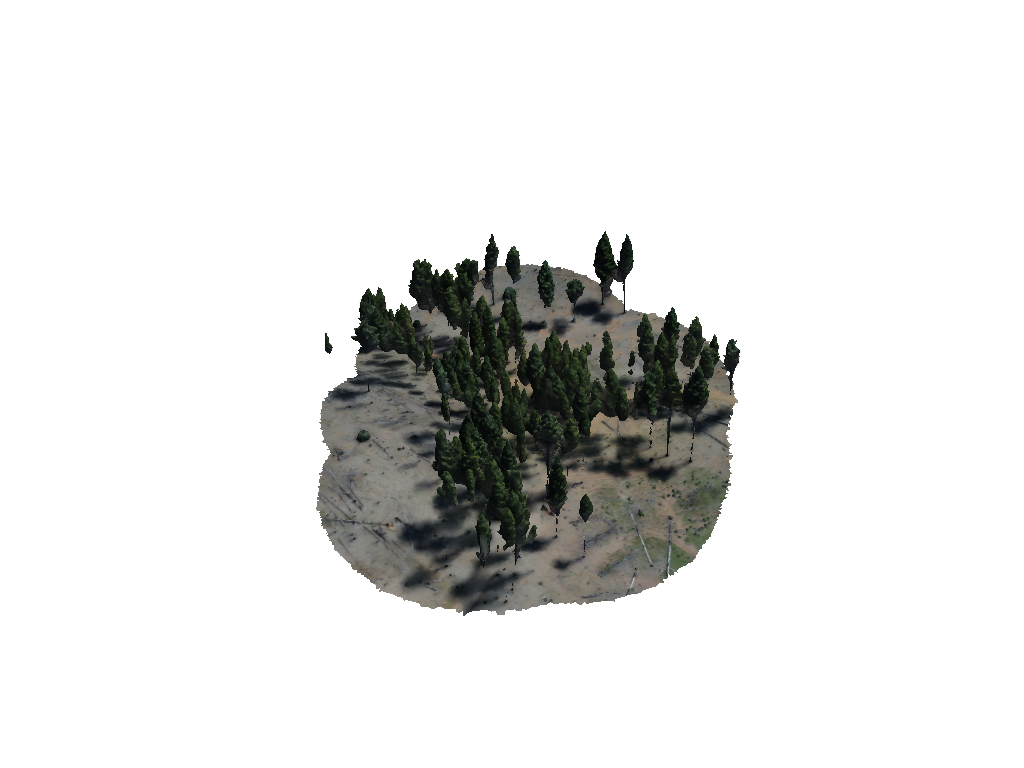

In [7]:
mesh = TexturedPhotogrammetryMesh(
    MESH_FILENAME,
    transform_filename=CAMERAS_FILENAME,
    ROI=LABELS_FILENAME,
    ROI_buffer_meters=BUFFER_RADIUS_METERS,
)
mesh.vis(force_xvfb=True)

/ofo-share/repos-david/conda/envs/MVMT-dev/lib/python3.9/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/ofo-share/repos-david/conda/envs/MVMT-dev/lib/python3.9/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/ofo-share/repos-david/conda/envs/MVMT-dev/lib/python3.9/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

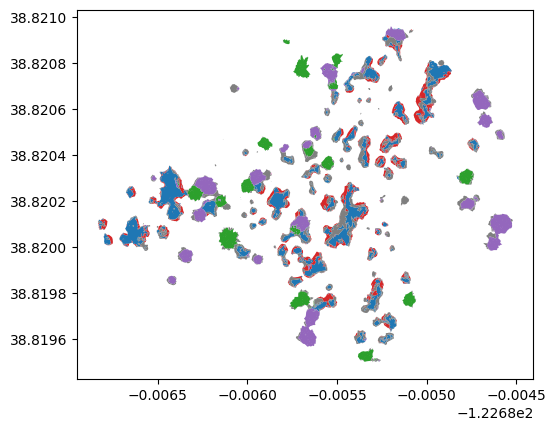

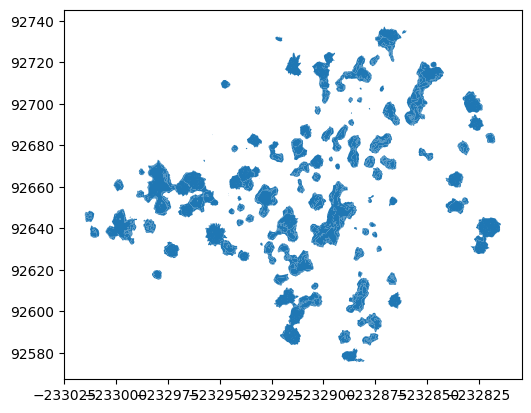

In [8]:
df = gpd.read_file(PREDICTED_VECTOR_LABELS_FILE)
df.plot("class_ID", cmap="tab10", vmin=-0.5, vmax=9.5)

class_fractions, IDs_in_original, unique_class_names = get_overlap_vector(
    unlabeled_df=LABELS_FILENAME,
    classes_df = PREDICTED_VECTOR_LABELS_FILE,
    class_column="class_ID"
)

[[1.65440448e+01 0.00000000e+00 2.01196819e+01 0.00000000e+00
  0.00000000e+00 1.48405704e+01]
 [1.23497958e+00 0.00000000e+00 6.45382355e-03 1.15221885e-01
  0.00000000e+00 6.23478233e+00]
 [3.22418849e+00 0.00000000e+00 9.01305582e-02 0.00000000e+00
  0.00000000e+00 6.81557306e+00]
 [1.23937654e+01 0.00000000e+00 5.97474910e+00 0.00000000e+00
  0.00000000e+00 1.40040995e+01]
 [6.67508249e+00 0.00000000e+00 1.94541705e-01 7.97447526e+00
  0.00000000e+00 1.53964983e+01]
 [5.09826058e-01 0.00000000e+00 1.09102167e-01 0.00000000e+00
  0.00000000e+00 2.15924030e+00]
 [4.90056807e-02 2.58329547e+01 1.26329563e-02 0.00000000e+00
  0.00000000e+00 2.93629086e+00]
 [6.15750199e+00 0.00000000e+00 7.69839036e+00 0.00000000e+00
  0.00000000e+00 4.25469951e+00]
 [3.78123850e+00 0.00000000e+00 5.02353720e+00 0.00000000e+00
  0.00000000e+00 2.96111874e+00]
 [6.83958452e+00 0.00000000e+00 3.54378125e+00 0.00000000e+00
  0.00000000e+00 5.88288387e+00]
 [7.44653968e+00 1.11026698e-01 2.49054612e+00 0.0

/ofo-share/repos-david/conda/envs/MVMT-dev/lib/python3.9/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


<Axes: >

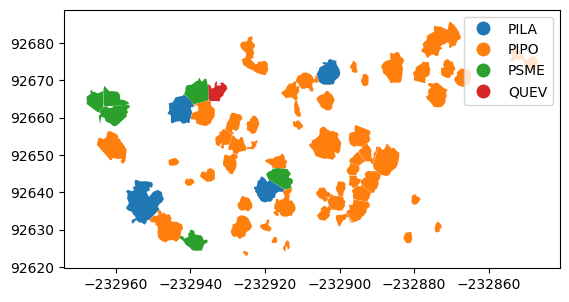

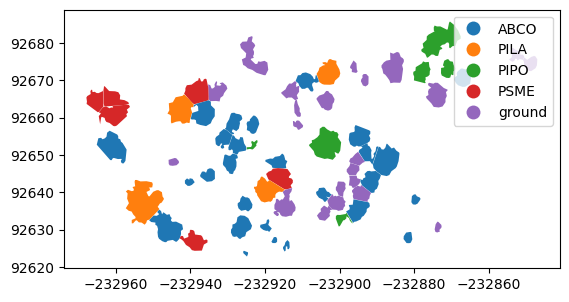

In [13]:
print(class_fractions)
print(IDs_in_original)
print(unique_class_names)
pred_IDs = np.argmax(class_fractions, axis=1)

pred_IDs = [int(unique_class_names[i]) for i in pred_IDs]
pred_class = [IDs_TO_LABELS[pred_ID] for pred_ID in pred_IDs]

# Load the data
gdf = gpd.read_file(LABELS_FILENAME)
site_gdf = gdf.iloc[IDs_in_original]
site_gdf["pred_class"] = pred_class
print("Ground truth")
site_gdf.plot(LABELS_COLUMN, legend=True, vmin=-0.5, vmax=9.5)
print("Predicted")
site_gdf.plot("pred_class", legend=True, vmin=-0.5, vmax=9.5)

GT classes ['PIPO', 'PIPO', 'PIPO', 'PIPO', 'PIPO', 'PIPO', 'PILA', 'PIPO', 'PIPO', 'PIPO', 'PIPO', 'PIPO', 'QUEV', 'PIPO', 'PSME', 'PIPO', 'PIPO', 'PSME', 'PSME', 'PILA', 'PIPO', 'PSME', 'PIPO', 'PIPO', 'PIPO', 'PIPO', 'PIPO', 'PIPO', 'PIPO', 'PIPO', 'PIPO', 'PIPO', 'PIPO', 'PIPO', 'PIPO', 'PIPO', 'PIPO', 'PIPO', 'PIPO', 'PIPO', 'PSME', 'PIPO', 'PIPO', 'PIPO', 'PILA', 'PIPO', 'PIPO', 'PIPO', 'PIPO', 'PILA', 'PIPO', 'PIPO', 'PIPO', 'PIPO', 'PIPO', 'PIPO', 'PIPO', 'PIPO', 'PIPO', 'PIPO', 'PIPO', 'PIPO', 'PSME', 'PIPO', 'PIPO']
Pred classes ['PIPO', 'ground', 'ground', 'ground', 'ground', 'ground', 'PILA', 'PIPO', 'PIPO', 'ABCO', 'ABCO', 'ground', 'ground', 'ground', 'PSME', 'ground', 'ground', 'PSME', 'PSME', 'PILA', 'ground', 'PSME', 'ABCO', 'ABCO', 'ABCO', 'ground', 'ABCO', 'ABCO', 'PIPO', 'ABCO', 'PIPO', 'ABCO', 'ABCO', 'ABCO', 'ABCO', 'ground', 'ground', 'ABCO', 'ground', 'ABCO', 'PSME', 'ABCO', 'ground', 'ABCO', 'PILA', 'ground', 'ground', 'ABCO', 'ABCO', 'PILA', 'ABCO', 'ground', 

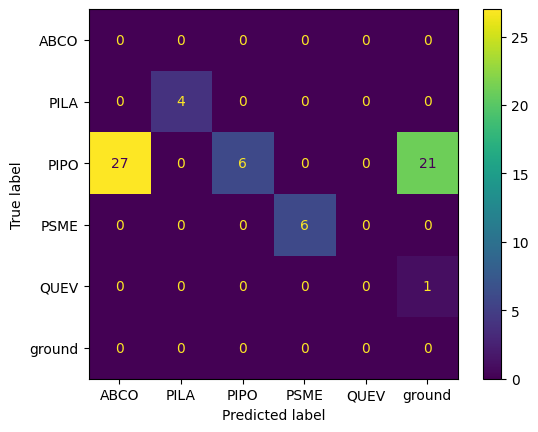

(array([[ 0,  0,  0,  0,  0,  0],
        [ 0,  4,  0,  0,  0,  0],
        [27,  0,  6,  0,  0, 21],
        [ 0,  0,  0,  6,  0,  0],
        [ 0,  0,  0,  0,  0,  1],
        [ 0,  0,  0,  0,  0,  0]]),
 array(['ABCO', 'PILA', 'PIPO', 'PSME', 'QUEV', 'ground'], dtype='<U6'),
 0.24615384615384617)

In [14]:
gt_list = site_gdf[LABELS_COLUMN].tolist()
pred_list = site_gdf["pred_class"].tolist()
print(f"GT classes {gt_list}")
print(f"Pred classes {pred_list}")

compute_and_show_cf(pred_labels=pred_list, gt_labels=gt_list)